In [1]:
import os

import polars as pl

# Load MTurk workers answers and decisions

In [2]:
mturk_ws_decisions_file = 'manual_decision_answers_30_September_12_25.xlsx'
mturk_df = pl.read_excel(mturk_ws_decisions_file)
print("# Answers", len(mturk_df))
mturk_df.head(5)

# Answers 19219


hit_id,assign_id,worker_id,worker_name,ingredient_index,ingredient,answer_path,answer_level_path,Decision,Comment,Colonna1
str,str,str,str,i64,str,str,str,str,str,str
"""3WJGKMRWW3MHF2BY2CG807C2EA0DCA""","""3DQQ64TAN2Y25HHNEEC51EWNG1PWPP""","""A1SMKHKMXWYIMW""","""A.Lala Hanitra""",17161,"""monterey jack and cheddar chee…","""ANIMAL DERIVED -> CHEESE (GENE…","""level0 -> level1 -> level2 -> …","""x""",null,null
"""3SX4X51T9LMKQK5P87YX56YDILMAO2""","""3VBEN272M6C3LN7FRQCHAGFA9X4GSO""","""A1SMKHKMXWYIMW""","""A.Lala Hanitra""",17263,"""white port""","""AGRICULTURAL PROCESSED -> WINE…","""level0 -> level1 -> level2""","""x""",null,null
"""37VUR2VJ7V2NN7VMMJWDZ5BTPDU1C5""","""3PM8NZGV8KT2UTNSOWNG3204UB5QXF""","""A1SMKHKMXWYIMW""","""A.Lala Hanitra""",12947,"""pierogies""","""AGRICULTURAL PROCESSED -> BREA…","""level0 -> level1 -> level2 -> …","""x""",null,null
"""3AFT28WXM0FZW2ONKVQAM4MWVTOIOB""","""3RWE2M8QW3N9U64P5S6SQUIOFSN0NV""","""A1SMKHKMXWYIMW""","""A.Lala Hanitra""",13942,"""hamburger bun""","""AGRICULTURAL PROCESSED -> GRAI…","""level0 -> level1 -> level2""","""WRONG""","""The taxonomy also had SPECIES …",null
"""3IJ95K7NEIP3IQIGTSQUM39BQ6QNG8""","""3XCC1ODXD7OIXX1GFXHOEKEGTUMRQM""","""A1SMKHKMXWYIMW""","""A.Lala Hanitra""",12812,"""calorie - reduced mayonnaise""","""ANIMAL DERIVED -> EGGS*""","""level0 -> level1""","""x""",null,null


Retrieve only accepted answers (Decision in ['x', 'x (CHECK)'], but 'x (CHECK)' must be checked.

In [3]:
accepted_mturk_df = mturk_df.filter(pl.col('Decision').is_in(['x', 'x (CHECK)']))
print("# Accepted Answers", len(accepted_mturk_df))

# Accepted Answers 4311


Count number of answers for each unique ingredient

In [4]:
answers_per_ingredient_df = accepted_mturk_df.group_by(pl.col('ingredient')).len()
ingredients_with_multiple_answers = answers_per_ingredient_df.filter(pl.col('len') > 1)['ingredient'].to_numpy()

<Axes: xlabel='AnswersPerIngredient', ylabel='Count'>

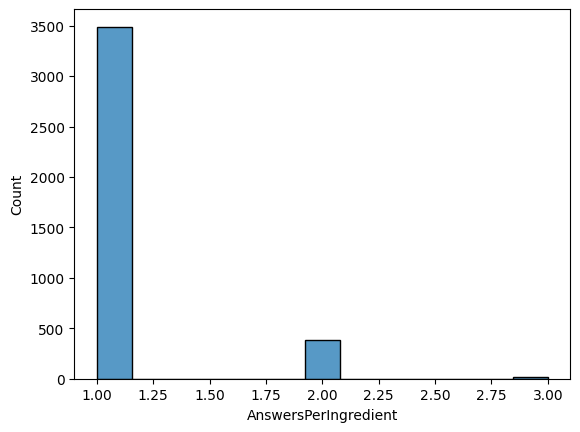

In [5]:
import seaborn as sns
%matplotlib inline
sns.histplot(answers_per_ingredient_df.to_pandas().rename(columns={'len': 'AnswersPerIngredient'}), x='AnswersPerIngredient')

Get answers_path of ingredients with multiple answers

In [6]:
multi_ans_df = accepted_mturk_df.filter(pl.col('ingredient').is_in(ingredients_with_multiple_answers))
multi_ans_path_sort_df = multi_ans_df.select(pl.col(['ingredient', 'answer_path'])).sort('ingredient')
with pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000, tbl_rows=100):
    display(multi_ans_path_sort_df)

ingredient,answer_path
str,str
"""""orange, zest of""""","""CROPS -> FRUIT (GENERIC) -> I DON'T KNOW"""
"""""orange, zest of""""","""CROPS -> FRUIT (GENERIC) -> FRUIT LOCAL -> ORANGE"""
"""2% fat cottage cheese""","""ANIMAL DERIVED -> CHEESE (GENERIC) -> CHEESE FRESH -> I DON'T KNOW"""
"""2% fat cottage cheese""","""ANIMAL DERIVED -> CHEESE (GENERIC) -> CHEESE FRESH -> I DON'T KNOW"""
"""9 - grain bread""","""AGRICULTURAL PROCESSED -> BREAD (GENERIC) -> BREAD -> BREAD MULTICEREAL**"""
"""9 - grain bread""","""AGRICULTURAL PROCESSED -> BREAD (GENERIC) -> BREAD -> BREAD MULTICEREAL**"""
"""Baby Spinach""","""CROPS -> VEGETABLES (GENERIC) -> VEGETABLES LOCAL -> SPINACH"""
"""Baby Spinach""","""CROPS -> VEGETABLES (GENERIC) -> VEGETABLES LOCAL -> SPINACH"""
"""Barilla lasagna""","""AGRICULTURAL PROCESSED -> PASTA (GENERIC) -> PASTA*"""


Filters only ingredients with multiple answers that are different from each other to fix them manually

In [89]:
answer_path_per_ingr = multi_ans_path_sort_df.group_by('ingredient').agg('answer_path')
unique_ans_per_ingr = answer_path_per_ingr.select(pl.col('answer_path').list.unique().list.len())['answer_path']
collisions_answers_per_ingr = answer_path_per_ingr.filter(unique_ans_per_ingr > 1).explode('answer_path')
collisions_answers_per_ingr.write_csv('first_ingredient_collision.csv', separator='\t')

Retrieve reviewed and fixed collisions and use it to update the dataframe

In [7]:
fixed_collisions_answers_per_ingr = pl.read_csv('first_ingredient_collision_reviewed.csv', separator=';')
joined_collisions_df = accepted_mturk_df.join(fixed_collisions_answers_per_ingr, how='left', on='ingredient', suffix='_new')
new_answers_path = joined_collisions_df.select(pl.col('ingredient'), pl.col('answer_path_new').alias('answer_path'))
new_answers_path

/tmp/ipykernel_1384802/2661873076.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  joined_collisions_df = accepted_mturk_df.join(fixed_collisions_answers_per_ingr, how='left', on='ingredient', suffix='_new')


ingredient,answer_path
str,str
"""monterey jack and cheddar chee…",null
"""white port""",null
"""pierogies""",null
"""calorie - reduced mayonnaise""",null
"""Mrs Richardson\'s caramel topp…",null
…,…
"""Dutch - processed cocoa powder""",null
"""pork tenderloin""","""MEAT PRODUCTS -> PORK MEAT -> …"
"""pork tenderloin""","""MEAT PRODUCTS -> PORK MEAT -> …"


In [8]:
accepted_mturk_df.filter(pl.col('ingredient') == 'pork tenderloin')

hit_id,assign_id,worker_id,worker_name,ingredient_index,ingredient,answer_path,answer_level_path,Decision,Comment,Colonna1
str,str,str,str,i64,str,str,str,str,str,str
"""39AYGO6AG0X1LXTAHFH8ACWMWSJ6NL""","""32N49TQG32VI3OBGZLPCPHOEAE8AVE""","""A267R298DA9HV9""","""Jonathan Hawkins""",8075,"""pork tenderloin""","""MEAT PRODUCTS -> PORK MEAT -> …","""level0 -> level1 -> level2""","""x""",null,"""FLAG"""
"""39AYGO6AG0X1LXTAHFH8ACWMWSJ6NL""","""3R0T90IZ1EPNE6IJU4MHVBBSNTLCGR""","""A1ARY2P1UWNNRD""","""will""",8075,"""pork tenderloin""","""MEAT PRODUCTS -> PORK MEAT -> …","""level0 -> level1 -> level2""","""x""",null,null


In [9]:
with pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000, tbl_rows=100):
    display(accepted_mturk_df.filter(pl.col('ingredient') == 'pork tenderloin').join(fixed_collisions_answers_per_ingr.unique(), how='inner', on='ingredient'))

hit_id,assign_id,worker_id,worker_name,ingredient_index,ingredient,answer_path,answer_level_path,Decision,Comment,Colonna1,answer_path_right
str,str,str,str,i64,str,str,str,str,str,str,str
"""39AYGO6AG0X1LXTAHFH8ACWMWSJ6NL""","""32N49TQG32VI3OBGZLPCPHOEAE8AVE""","""A267R298DA9HV9""","""Jonathan Hawkins""",8075,"""pork tenderloin""","""MEAT PRODUCTS -> PORK MEAT -> I DON'T KNOW""","""level0 -> level1 -> level2""","""x""",null,"""FLAG""","""MEAT PRODUCTS -> PORK MEAT -> PORK BONE FREE MEAT*"""
"""39AYGO6AG0X1LXTAHFH8ACWMWSJ6NL""","""3R0T90IZ1EPNE6IJU4MHVBBSNTLCGR""","""A1ARY2P1UWNNRD""","""will""",8075,"""pork tenderloin""","""MEAT PRODUCTS -> PORK MEAT -> PORK BONE FREE MEAT*""","""level0 -> level1 -> level2""","""x""",null,null,"""MEAT PRODUCTS -> PORK MEAT -> PORK BONE FREE MEAT*"""


In [24]:
accepted_mturk_df_clean = accepted_mturk_df.select(pl.all().exclude('ingredient'), pl.col('ingredient').str.replace_all(r'"', ''))

In [41]:
accepted_mturk_df_with_fixed_collisions = accepted_mturk_df_clean.join(
    fixed_collisions_answers_per_ingr.unique(), how='left', on='ingredient', coalesce=False
).with_columns(
    pl.coalesce(["ingredient_right", "ingredient"]).alias("ingredient"),
    pl.coalesce(["answer_path_right", "answer_path"]).alias("answer_path"),
).drop(["ingredient_right", "answer_path_right"])

In [45]:
accepted_mturk_df_with_fixed_collisions.rename({'Colonna1': 'Bot'}).write_csv('accepted_mturk_df_with_fixed_collisions.csv', separator='\t')